Monika Helak

# <h1><center> Movie Reviews Sentiment Analysis </center></h1>






Deriving meaning from text is highly in demand across disciplines in data science. Sentiment Analysis is one common application of NLP. This project served as an exercise to practice NLP concepts and test out the performance of different models on text data.

The objective of the project was to build a classification model that is able to classify IMDB movie reviews as positive or negative based on their text descriptions. The project was inspired by a former Kaggle competition. The data can be found here: http://ai.stanford.edu/~amaas/data/sentiment/\

I created a model that can accurately predict a binary outcome for both types of reviews with equal importance. The steps to build the model included exploratory data analysis, statistical testing, building three different models, and evaluating the performance of my models by looking at assumptions, advantages and disadvantages as well as their F1 score. 

In [4]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import time

## Loading the Data

First, we need to load the data. The data is stored in two separate folders, each of which contains the test and train set.

In [5]:
def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r", encoding="utf-8") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])        
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])

    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])

    return data["train"], data["test"]

In [6]:
train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

The length of both the train_data and test_data is the same.

In [7]:
print(len(train_data))
print(len(test_data))

25000
25000


In [8]:
frames = [train_data, test_data]

df = pd.concat(frames, ignore_index = True)

The two dataframes are now both in one single dataframe. I'll do a 75/25 train test split when ready to train the models later.

In [9]:
df.shape

(50000, 2)

## Preprocessing

The possibilities are endless when it comes to preprocessing text data. However, the key steps remain the same. Some high-yield data cleaning steps to ensure good model performance include conversion of all text to lowercase as well as removal of extraneous symbols and punctuation.

In [10]:
def preprocess(text):
    # everything to lowercase
    # replacing breaks with spaces
    # remove punctuation
     
    text = text.lower()
    text = text.replace('<br />', '')
    text = re.sub(r'[^\w\s]','', text)

    return  text

In [11]:
df['text'] = df['text'].apply(preprocess)

## Stemming

An easy way to reduce the dimensions of the dataset is to reduce the number of distinct words that the model takes into account by shortening each word to include only its stem, and ignoring any subsequent tenses or conjugations. The objective here is to shorten the word to only include the root word. There are two main simple stemmers available in NLTK, the simplest of which is PorterStemmer. Applying the stemmer to my text data will greatly reduce the number of distinct words that the model will be considering.

In [12]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

from nltk.tokenize import sent_tokenize, word_tokenize
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [13]:
#for the whole dataframe
df['text'] = df['text'].apply(stemSentence)

## Only alphabetic words

At the end of this step we want a list of words for each review, so that this does not include any numbers or other symbols. This is the bag of words.

In [14]:
from nltk import word_tokenize

def is_alpha_tokenize(text):
    words = word_tokenize(text)
    words = ' '.join([word for word in words if word.isalpha()])
    return(words)

In [15]:
df['text'] = df['text'].apply(is_alpha_tokenize)

## Vectorization 

Each word in the bag of words gets an integer which will be used to encode the text in the dataframe.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


# Create a series to store the labels: y
y = df['sentiment']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:12])



#Tfidf Vectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features of the count_vectorizer
print(tfidf_vectorizer.get_feature_names()[:12])



['aa', 'aaa', 'aaaaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaargh', 'aaaaaaah', 'aaaaaaahhhhhhggg', 'aaaaah', 'aaaaargh', 'aaaaarrrrrrgggggghhhhhh', 'aaaaatchkah', 'aaaaaw', 'aaaahhhhhhh']
['aa', 'aaa', 'aaaaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaargh', 'aaaaaaah', 'aaaaaaahhhhhhggg', 'aaaaah', 'aaaaargh', 'aaaaarrrrrrgggggghhhhhh', 'aaaaatchkah', 'aaaaaw', 'aaaahhhhhhh']


The above cells do not appear to be too useful. I will try again to look at more useful words by picking only the top 20 words with the highest TFIDF score. I will do the same for the top 20 words from the Count Vectorizer.

In [17]:
vect = TfidfVectorizer(stop_words = 'english', max_features=20)
top_20_vect=vect.fit_transform(X_train)
print(vect.get_feature_names())

['charact', 'end', 'film', 'good', 'ha', 'hi', 'just', 'like', 'look', 'make', 'movi', 'onli', 'realli', 'scene', 'stori', 'thi', 'time', 'veri', 'wa', 'watch']


In [18]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))

   aa  aaa  aaaaaaaaaaaahhhhhhhhhhhhhh  aaaaaaaargh  aaaaaaah  \
0   0    0                           0            0         0   
1   0    0                           0            0         0   
2   0    0                           0            0         0   
3   0    0                           0            0         0   
4   0    0                           0            0         0   

   aaaaaaahhhhhhggg  aaaaah  aaaaargh  aaaaarrrrrrgggggghhhhhh  aaaaatchkah  \
0                 0       0         0                        0            0   
1                 0       0         0                        0            0   
2                 0       0         0                        0            0   
3                 0       0         0                        0            0   
4                 0       0         0                        0            0   

   ...  østbye  úbercrap  über  überannoy  überbab  übertrash  überwoman  \
0  ...       0         0     0          0        0        

In [19]:
vect_c = CountVectorizer(stop_words = 'english', max_features=20)
top_20_vect=vect_c.fit_transform(X_train)
print(vect_c.get_feature_names())

['charact', 'end', 'film', 'good', 'ha', 'hi', 'just', 'like', 'look', 'make', 'movi', 'onli', 'realli', 'scene', 'stori', 'thi', 'time', 'veri', 'wa', 'watch']


For both the Tfidf vectorizer and the Count vectorizer, the top 20 feature names appear to be the same. Still, the difference comparison shows that while similar, the two vectorizers are not the same, and training the same model on both vectorizers will result in different performance. I am inclined towards using Tfidf as this one downplays (if only slightly) the significance of common words like 'just' 'look' and 'watch'.

# <h1><center> Exploratory Data Analysis </center></h1> 

Three things worth visualizing in this dataset include:
- Barplot of the Target Variable

The objective is to see whether the data is balanced or not. If not balanced, there need to be some steps taken to account for an imbalanced dataset.
- Distribution of the number of words in a review

This step is important to help decide what the dimensions of the input variable should be. When we feed data into the model, all the reviews must be of a fixed size.
- Word cloud of positive and negative reviews

Straightforward visualization technique to see what kind of words are often ocurring in each kind of review.


In [20]:
import seaborn as sns
df.head()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,text,sentiment
0,im not sure whi thi littl film ha been banish ...,1
1,i complet agre with thi wa the singl most horr...,0
2,the fulli round charact of the princip role of...,1
3,major spoiler thi is for peopl who have seen t...,1
4,fulci experi with sci fi and fail usual in hi ...,0


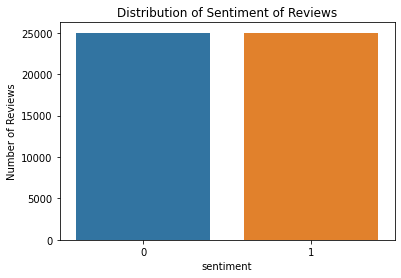

In [21]:
ax = sns.countplot(x = "sentiment", data = df).set(title="Distribution of Sentiment of Reviews", ylabel= "Number of Reviews")

As we can see the dataset is balanced. No techniques for imbalanced datasets are needed.

## Number of Words in a Review

It would be interesting to see the distribution of the number of words in a review. Are people writing short reviews? Long reviews?

In [22]:
from collections import Counter

df['number_of_words'] = df['text'].apply(lambda x: len(x))

In [23]:
df.head()

,text,sentiment,number_of_words
0,im not sure whi thi littl film ha been banish ...,1,2035
1,i complet agre with thi wa the singl most horr...,0,668
2,the fulli round charact of the princip role of...,1,871
3,major spoiler thi is for peopl who have seen t...,1,3658
4,fulci experi with sci fi and fail usual in hi ...,0,496


In [24]:
#!pip install -U seaborn

In [25]:
import seaborn as sns

Text(0, 0.5, 'Number of Reviews')

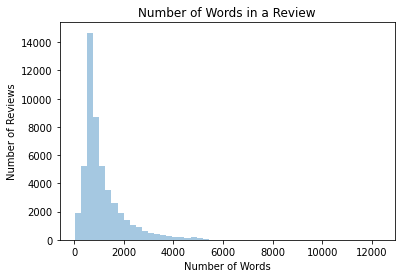

In [26]:
from scipy.stats import norm
ax = sns.distplot(df["number_of_words"], kde = False)
ax.set_title("Number of Words in a Review")
ax.set_xlabel("Number of Words")
ax.set_ylabel("Number of Reviews")

In [27]:
df['number_of_words'].mean()

1133.5189

The number of words seems a little high. This begs the question of whether the mean number of words in a review is different for positive vs. negative ratings.

,mean,std
sentiment,,
0,1118.92668,816.636686
1,1148.11112,891.581934


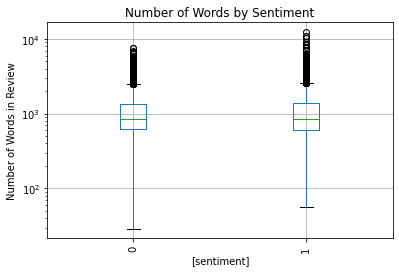

In [28]:
df.boxplot(column=['number_of_words'],by = ['sentiment'], rot=90).set_yscale('log')
plt.ylabel("Number of Words in Review")
plt.title('Number of Words by Sentiment')
plt.suptitle('')
pd.DataFrame(df.groupby( ['sentiment'])['number_of_words'].describe().loc[:,['mean','std']])

In [29]:
data1 = df[df['sentiment'] == 1]['number_of_words']
data2 = df[df['sentiment'] == 0]['number_of_words']

print('Mean number of words for positive review: ',data1.mean())
print('Mean number of words for negative review: ',data2.mean())

Mean number of words for positive review:  1148.11112
Mean number of words for negative review:  1118.92668


There appears to be a slight difference in that the mean number of words based on sentiment. It is appropriate to see whether this difference is significant with a t-test.

In [30]:
import statsmodels.stats.weightstats
results = statsmodels.stats.weightstats.ttest_ind(data1, data2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)
print('t-statistic: ' + str(results[0]) + ' p-value: ' + str(results[1]) + ' degrees of freedom: ' + str(results[2]))

t-statistic: 3.8165884937183763 p-value: 0.00013547246149710947 degrees of freedom: 49998.0


The p-value is < 0.05 so we can reject the null hypothesis that the two means are the same. There is reasonable evidence to assume that they are different, meaning that the number of words could potentially be included as a feature in the model.

## Make a Word Cloud

In [31]:
#!pip install wordcloud

In [32]:
#all of the words from all of the reviews are included in this string that makes wordcloud
word_cloud_string = df.text.str.cat(sep=' ')

In [33]:
import matplotlib.pyplot as pPlot
from wordcloud import WordCloud, STOPWORDS
import numpy as npy
from PIL import Image
def create_word_cloud(string):
   cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS))
   cloud.generate(string)
   cloud.to_file("wordCloud.png")
create_word_cloud(word_cloud_string)

The first wordcloud mostly yields obvious words that are common in both reviews. It is not surprising that the words movie and film are some of the words that appear the most. Another option is to look at a word cloud composed of the words that are filtered down to the most important features of the dataset, (setting a minimum frequency for the Tfidf vectorizer) and making a wordcloud from this data.

# <h1><center> Modeling </center></h1>

I will be trying out three different models: Logistic Regression, Naive Bayes and Decision Tree Classifier. Then I will be performing model selection on the basis of advantage and disadvantages as well as assumptions met for the tried models. Upon selecting a model, I'll be performing hyperparameter tuning for the chosen one.

I will be using F1-score to evaluate the performance of the classification model. The F1-score is the harmonic mean of the precision and recall of the model. Since classifying positive and negative reviews is equally important for my business use case, the F-1 score appears to be a reasonable choice.

The Naive Bayes model trains the fastest so I will be using this model to see whether there are major differences in the performance when training on CountVectorizer vs TfidfVectorizer.

## Naive Bayes

In [34]:
#naive bayes - TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB()

# Fit the classifier to the training data
start = time.time()
nb_classifier.fit(tfidf_train, y_train)
stop = time.time()
time_spent = stop-start
print(f"Training time: {time_spent}s")

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[1, 0])
print(cm)

from sklearn.metrics import f1_score
print('F1-score: ',f1_score(y_test, pred))

Training time: 0.12906694412231445s
0.8573939393939394
[[6993 1175]
 [1178 7154]]
F1-score:  0.8559887386008936


In [35]:
#naive bayes - CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB()

# Fit the classifier to the training data
start = time.time()
nb_classifier.fit(count_train, y_train)
stop = time.time()
time_spent = stop-start
print(f"Training time: {time_spent}s")

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[1, 0])
print(cm)

from sklearn.metrics import f1_score
print('F1-score: ',f1_score(y_test, pred))

Training time: 0.22095727920532227s
0.8473333333333334
[[6777 1391]
 [1128 7204]]
F1-score:  0.8432775461954832


After looking at a few runs, the accuracy is slightly higher when using the TfidfVectorizer. The training time is slightly lower when using the CountVectorizer. I chose to use the TfidfVectorizer going forward with the other models due to the slight improvement in performance.

## Logistic regression model


In [36]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression() 

start = time.time()
logreg.fit(tfidf_train, y_train)
stop = time.time()
time_spent = stop-start
print(f"Training time: {time_spent}s")

# Create the predicted tags: pred
pred = logreg.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[1, 0])
print(cm)

from sklearn.metrics import f1_score
print('F1-score: ',f1_score(y_test, pred))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training time: 3.150567054748535s
0.8862424242424243
[[7376  792]
 [1085 7247]]
F1-score:  0.8871249022791509


The performance of the logistic regression model is rather good. The training time is also short. A logistic regression tends to perform well when the X features are not correlated or highly nonlinear. This largely makes sense as we can assume the distinct words in text are not correlated with each other.

## Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
desc_tree=DecisionTreeClassifier()

start = time.time()
desc_tree.fit(tfidf_train, y_train)
stop = time.time()
time_spent = stop-start
print(f"Training time: {time_spent}s")

# Create the predicted tags: pred
pred = desc_tree.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[1, 0])
print(cm)

from sklearn.metrics import f1_score
print('F1-score: ',f1_score(y_test, pred))

Training time: 130.47233271598816s
0.716
[[5823 2345]
 [2341 5991]]
F1-score:  0.713078618662748


It can be seen that the decision tree model performs the worst out of the three. It is possible to improve this performance with some hyperparameter tuning. In order to check whether the model is overfitting or underfitting, it is advisable to check the performance of the model on the training set.

In [38]:
start = time.time()
desc_tree.fit(tfidf_train, y_train)
stop = time.time()
time_spent = stop-start
print(f"Training time: {time_spent}s")

# Create the predicted tags: pred
pred = desc_tree.predict(tfidf_train)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_train, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_train, pred, labels=[1, 0])
print(cm)

Training time: 114.27309393882751s
1.0
[[16832     0]
 [    0 16668]]


Fitting the decision tree model to the training set results in an accuracy score of 1.0. It becomes clear then that the decision tree model is overfitting. A way to reduce overfitting would be to 'prune' the decision tree by reducing the max_depth of the tree. Still, I am probably not interested in using this model.

## Model Selection

|  | Decision Tree | Logistic Regression | Naive Bayes |
| --- | --- | --- | --- |
| Advantages |  Does not require normalization | Simple interpretation | Efficient time and space complexity |
| Disadvantages | Prone to overfitting | Independent variables must be linearly related to log odds| Only works well when features are independent |
| Accuracy | 0.709 | 0.885| 0.852 |
| F1-Score | 0.715 | 0.887 | 0.853 |
| Training Time | 157.19s |  5.46s| 0.31s |


Based on the above advantages/disadvantages both Naive Bayes and Logistic Regression seem to be good candidates for the final model for deployment.

Logistic regression is not restricted as linear regression as fewer assumptions need to be checked. It does not require a linear relationship between the dependent and independent variables, does not require the error terms to be normally distributed and does not require homoscedasticity. It does however require independence, absence of multicollinearity, and the linearity of independent variables and log odds. For the dataset I'm currently using, these do appear to be met. If all of the values our scaled (in our example they are) we can also directly look at the output of the ols linear regression model and look at the coefficients to judge feature importance based on the size of their coefficients.

Naive Bayes is also a competitive choice for sentiment analysis with text. It uses conditional probability distributions to train on the training set and is able to do so very efficiently in terms of time and space. However, it is not as easily interpretable as linear regression. To use this algorithm, it is also very important for the features to be completely independent. 

Given the above advantages and disadvantages of both algorithms, I chose Naive Bayes as the best model choice for this problem use case.

## Hyperparameter Tuning

There aren't too many hyperparameters to tune with a Naive Bayes model. Two main ones include the number of priors the var_smoothing. However, due to time constraints and the overal satisfactory performance of the model, I was not able to dive into this topic in depth. The overal code for tuning hyperparameters if so desired would look approximately like this:

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv_method = RepeatedStratifiedKFold(n_splits=3,  n_repeats=1, random_state=999)

from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,1, num=100)}

from sklearn.model_selection import GridSearchCV
gs_NB = GridSearchCV(estimator=nb_classifier, param_grid=params_NB, cv=cv_method,verbose=1,scoring='accuracy')
Data_transformed = PowerTransformer().fit_transform(tfidf_test.toarray())
gs_NB.fit(Data_transformed, y_test);

results_NB = pd.DataFrame(gs_NB.cv_results_['params'])

results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

# predict the target on the test dataset
predict_test = gs_NB.predict(Data_transformed)
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

### Shortcomings and Limitations of the Analysis

Ultimately the project was successful in that I was able to build a classification model that was able to predict whether a movie review was positive or negative based on the text description. Some areas of improvement that could be addressed if this project were to be worked on further include:


- More extensive data preprocessing: This is the biggest one. There is room for improvement in preprocessing of the data. The dimensions of the dataset could be reduced further to exclude words that are common across any text. Also, instead of stemming, lemmatization could be applied to differentiate between word tenses. There is also a room for filtering out onomatopoeia and other alphabetic nonsense that does not help distinguish sentiment.

- Number of words and number of unique words in a review could be further explored, and the dataset could be modified to include length of the review as a possible additional feature.

- There are many types of Naive Bayes models that can be explored: Gaussian, Multinomial and Bernoulli. After trying out these different types of models, a more expansive GridSearch hyperparameter tuning endeavour could take place.